<a href="https://colab.research.google.com/github/Song-z-h/black-litterman-allocation/blob/master/bl_ricerca_operativa_song.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Black litterman portfolio Allocation  
This model is an example of using the [Black-litterman model](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) to calculate the posterior expected return, and then solve the quadratic equition using Gurobi solver. You can find a more specified problem setting [here](https://www.notion.so/Operational-Research-Project-1658df813e6448f791aa0cf0ffc28733?pvs=4)

A simple context is that we have N assets to invest in, we have 1 dollar, we want to know the fraction to be invested into each of the N assets, in order to maximize our future returns. 

## Install the libraries. 

In [502]:
!pip install pandas numpy matplotlib yfinance PyPortfolioOpt
!pip install gurobipy  # install gurobipy, if not already installed

import os
if not os.path.isdir('data'):
    os.system('git clone https://github.com/robertmartin8/PyPortfolioOpt.git')
    os.chdir('PyPortfolioOpt/cookbook')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [503]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

## Selecting your stocks
You can put some of your favourite stocks in the bracket, then choose the simulation day, that means if you were investing 1 dollar y years ago, you want to know how much you would make now!

In [504]:
tickers = ["MSFT", "AMZN", "BAC", "DPZ", "DIS", "KO", "JPM", "COST", "SBUX", "AAPL", "TSM", "GS", "AAL"]
simulation_day = 365 * 5

If you want to calculate for the future expected returns based on the data we know today, just put the simulation day to zero!

## Prepare the historic data
We want to know if we only had the data until y years ago, and did the predication based on the data we knew, how the performance would be today, you can use ctrl + f9 to do all the computation using default parameters, and check out the result at end of the page.

In [505]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  13 of 13 completed


,AAL,AAPL,AMZN,BAC,COST,DIS,DPZ,GS,JPM,KO,MSFT,SBUX,TSM
Date,,,,,,,,,,,,,
2023-05-08,14.36,173.260345,105.830002,27.690001,499.059998,102.970001,308.940002,326.510010,137.070007,63.919998,308.649994,106.639008,85.540001
2023-05-09,14.47,171.532745,106.620003,27.660000,500.790009,102.180000,308.640015,324.769989,136.410004,63.389999,307.000000,106.181290,85.059998
2023-05-10,14.34,173.320267,110.190002,27.320000,499.660004,101.139999,306.890015,322.549988,136.479996,63.500000,312.309998,106.440002,84.900002
2023-05-11,14.07,173.510010,112.180000,27.389999,501.890015,92.309998,306.929993,320.720001,136.050003,63.860001,310.109985,105.629997,83.430000
2023-05-12,14.02,172.570007,110.260002,27.090000,504.070007,91.989998,307.579987,319.500000,134.100006,64.110001,308.970001,106.120003,83.430000


In [506]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.tail()

[*********************100%***********************]  1 of 1 completed


Date
2023-05-08    412.739990
2023-05-09    410.929993
2023-05-10    412.850006
2023-05-11    412.130005
2023-05-12    411.589996
Name: Adj Close, dtype: float64

#Stock information
We get analysis's target price, market capital and sector informations from the api

In [507]:
mcaps = {}
targetPrices = {}
sectors = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
    targetPrices[t] = stock.info["targetMeanPrice"]
    #targetPrices[t] = stock.info["targetLowPrice"]
    #targetPrices[t] = stock.info["targetHighPrice"]
    sectors[t] = stock.info["sector"]
mcaps

{'MSFT': 2322178506752,
 'AMZN': 1131311792128,
 'BAC': 217717194752,
 'DPZ': 10869569536,
 'DIS': 184122572800,
 'KO': 277248802816,
 'JPM': 398833516544,
 'COST': 223546490880,
 'SBUX': 122630152192,
 'AAPL': 2729798795264,
 'TSM': 432674635776,
 'GS': 107231232000,
 'AAL': 9362051072}

## Stock covariance
I used a library to calculate the covariance vector between different assets, which we will use later to compute the prior(the asset prices knowing the potential risks)

In [508]:
from pypfopt import risk_models

cov_matrix = risk_models.CovarianceShrinkage(prices[:-simulation_day+1]).ledoit_wolf()
cov_matrix

,AAL,AAPL,AMZN,BAC,COST,DIS,DPZ,GS,JPM,KO,MSFT,SBUX,TSM
AAL,0.106536,0.014031,0.016229,0.033823,0.011090,0.015568,0.022666,0.022053,0.027485,0.007939,0.011055,0.017962,0.014317
AAPL,0.014031,0.144810,0.029662,0.028267,0.021811,0.026415,0.008475,0.019330,0.031018,0.016689,0.035152,0.020363,0.026846
AMZN,0.016229,0.029662,0.142418,0.025099,0.018505,0.021715,0.010948,0.023247,0.027440,0.007531,0.026361,0.024798,0.032866
BAC,0.033823,0.028267,0.025099,0.120020,0.021304,0.033390,0.015445,0.036888,0.063879,0.020986,0.025337,0.024293,0.022760
COST,0.011090,0.021811,0.018505,0.021304,0.062039,0.018670,0.006761,0.013445,0.023115,0.011955,0.020781,0.017003,0.016206
DIS,0.015568,0.026415,0.021715,0.033390,0.018670,0.101839,0.009190,0.018628,0.030977,0.026067,0.024143,0.017084,0.020264
DPZ,0.022666,0.008475,0.010948,0.015445,0.006761,0.009190,0.032402,0.011850,0.014831,0.004676,0.007790,0.012007,0.009913
GS,0.022053,0.019330,0.023247,0.036888,0.013445,0.018628,0.011850,0.048492,0.035142,0.006592,0.017959,0.016839,0.022780
JPM,0.027485,0.031018,0.027440,0.063879,0.023115,0.030977,0.014831,0.035142,0.090484,0.018335,0.028383,0.023124,0.026138
KO,0.007939,0.016689,0.007531,0.020986,0.011955,0.026067,0.004676,0.006592,0.018335,0.055784,0.015779,0.009713,0.006814


## Risk free rates
This will be the US 10 year treasury yield of today

In [509]:
risk_free_rates = 0.039

## Market implied risk return
We are trying to calculate the delta  $ δ=(R−R_f) / σ2$ that reflects the potential returns taking away the part of money you can earn from US 10 year bonds.

In [510]:
def market_implied_risk_premium(market_prices, frequency=252, risk_free_rates=0.02):
  if not isinstance(market_prices, (pd.Series, pd.DataFrame)):
    raise TypeError("Please format market_prices as a pd.Series")
  returns = market_prices.pct_change().dropna()
  r = returns.mean() * frequency
  variance = returns.var() * frequency
  delta = (r - risk_free_rates) / variance
  return delta
# 252 are the number of trading days in a year (us stock market)
delta = market_implied_risk_premium(market_prices[:-simulation_day+1], 252, risk_free_rates)
print(delta)

1.6866207436044989


You can see that by changing the risk_free_rate, you you will have a different delta, so this delta is dependent on the Fed's decision at every FOMC meeting.

## Market implied excess equilibrium returns
Here we will get the prior, which is the potential future returns we can get, considering the factors of each component, they are market capitals, covariance between assets. We get the prior by aplying this formula : $ Π=δΣwmkt $

In [511]:
def market_implied_returns(marketCap, delta, cov_matrix, risk_free_rate=0.02):
  mcaps = pd.Series(marketCap)
  mWeights = pd.Series(mcaps / mcaps.sum())
  pi = delta * cov_matrix.dot(mWeights) + risk_free_rate
  return pi

prior = market_implied_returns(mcaps, delta, cov_matrix, risk_free_rates)
tickers = prior.index.to_numpy()
print(prior)
tickers

AAL     0.063824
AAPL    0.154598
AMZN    0.111268
BAC     0.090626
COST    0.074916
DIS     0.083526
DPZ     0.054484
GS      0.073804
JPM     0.093911
KO      0.065950
MSFT    0.106917
SBUX    0.074117
TSM     0.085701
dtype: float64


array(['AAL', 'AAPL', 'AMZN', 'BAC', 'COST', 'DIS', 'DPZ', 'GS', 'JPM',
       'KO', 'MSFT', 'SBUX', 'TSM'], dtype=object)

In order to diversify in the market, we need to put a small portion of our money also in stocks that doesn't really have the best potential. Otherwise you will have greater flactuations

In [512]:
potential_view = pd.Series(targetPrices) / prices.tail(1) - 1
potential_view

,AAL,AAPL,AMZN,BAC,COST,DIS,DPZ,GS,JPM,KO,MSFT,SBUX,TSM
Date,,,,,,,,,,,,,
2023-05-12,0.201854,-0.052558,0.21277,0.229974,0.087408,0.23133,0.145035,0.212238,0.197912,0.089222,-0.019516,0.096306,0.234328


# View vector
We need to integrate our views on the stocks we are trying to invest. For example, if I think Apple are doing stock buy backs, I think APPL will increase 10% from now, Then I will put 0.10 in the array. For convenience, I downloaded the mean analysts' target prices, and let that price as potential gains. So you can leave this part, if you trust on wall street's analysts. 

In [513]:
#Q = np.array([0.20, 0.10, 0.05, 0.10])
'''Q = np.array([ 
     0.10,
     0.30,
     0.05,
     0.05,
     0.20,
     -0.05,  # I think Coca-Cola will go down 5%
     0.15,
     0.10,
     0.50,  # but low confidence, which will be reflected later
     0.10
] )
Q.reshape(-1, 1)'''
Q = potential_view.to_numpy().squeeze()
Q


array([ 0.20185445, -0.05255842,  0.21276979,  0.22997415,  0.08740848,
        0.23132952,  0.14503549,  0.21223787,  0.19791195,  0.08922164,
       -0.01951646,  0.09630604,  0.23432817])

The columns of P should be in the order as we can find in the series, which we will multiply later

## Picking vector
P is the vector that associates each view to our stocks. You can find how to specify this vector [here](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) 

In [514]:
#P = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0 ,0],
 #            [0, 0, 0, 0, 0, 0, 0, 0, 0 ,1],
  #           [0, 0, 0, 1, -1, 0, 0, 0, 0 ,0],
   #          [0, 0, 0, 0, 0, 0.5, 0.5, -0.5, -0.5 ,0]])
P = np.eye(len(tickers))
P

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [515]:
Q_P = Q @ P
Q_P = pd.Series(data=Q_P, index=tickers)
Q_P

AAL     0.201854
AAPL   -0.052558
AMZN    0.212770
BAC     0.229974
COST    0.087408
DIS     0.231330
DPZ     0.145035
GS      0.212238
JPM     0.197912
KO      0.089222
MSFT   -0.019516
SBUX    0.096306
TSM     0.234328
dtype: float64

# Confidence vector
Confidence is that you need to specify, how certain you were about your views, if you are 100% convinced that APPL will increase 10%, then you put 1; If you think you are half convinved you put 0.5. For convenience, I put a same value for every view, you can decide your confidence vectors.

In [516]:
variances = []
'''confidence_interval = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]
for ll, lh in confidence_interval:
  sigma = ((lh-ll) / 2) ** 2
  variances.append(sigma)'''

'''confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, 
    0.7, 
    0.7, 
    0.5,
    0.1,
    0.4
]'''
confidences = [0.1] * len(tickers)
variances = confidences

# Omega uncertainty matrix
$ Ω=τ∗PΣP^T $ is the formula I used to calcualte the uncertainty matrix, the more you are not sure about your views, the more you are uncertain to the view you gave to the asset.

In [517]:
tau = 0.05
def idzorek_method(tau, view_uncertainty, P, Q, S):
  view_omg = []
  for q_id in range(len(Q)):
    conf = view_uncertainty[q_id]
    if conf < 0 or conf > 1:
      raise ValueError("View confidences must be between 0 and 1")
    if conf == 0:
      view_omg.append(1e6)
      continue
    alpha = (1-conf)/conf
    P_view = P[q_id]
    omega = tau * alpha * P_view @ S @ P_view.T
    view_omg.append(omega)

  return np.diag(view_omg)

omega = idzorek_method(tau, variances, P, Q, cov_matrix)
pd.Series(data=np.diag(omega), index=tickers)

AAL     0.047941
AAPL    0.065164
AMZN    0.064088
BAC     0.054009
COST    0.027918
DIS     0.045828
DPZ     0.014581
GS      0.021821
JPM     0.040718
KO      0.025103
MSFT    0.030753
SBUX    0.032280
TSM     0.035333
dtype: float64

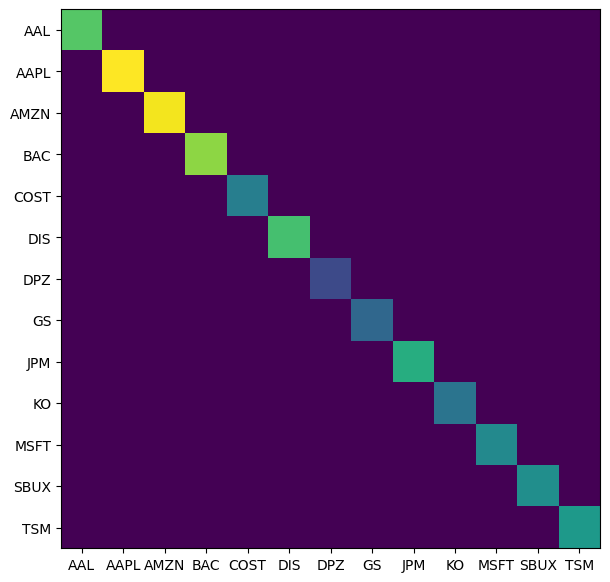

In [518]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(tickers)))
ax.set_yticks(np.arange(len(tickers)))

ax.set_xticklabels(tickers)
ax.set_yticklabels(tickers)
plt.show()

## Black litterman posterior excess returns

$ E(R)=[(τΣ)^{-1}+P^TΩ^{-1}P]^{-1}[(τΣ)^{-1}Π+P^TΩ^{-1}Q] $
 
$E(R)$
 is a Nx1 vector of expected returns, where N is the number of assets.

$Q$
 is a Kx1 vector of views.

$P$
 is the KxN picking matrix which maps views to the universe of assets. Essentially, it tells the model which view corresponds to which asset(s).

$Ω$ omega
 is the KxK uncertainty matrix of views.

$Π$ pi, prior
 is the Nx1 vector of prior expected returns.

$Σ$ sigma
 is the NxN covariance matrix of asset returns (as always)

$τ$
 is a scalar tuning constant.


In [519]:
tau_S_inv = np.linalg.inv(tau * cov_matrix)
omega_inv = np.linalg.inv(omega) 
expected_excess_returns = np.linalg.inv(tau_S_inv + (P.T @ omega_inv @ P)) @ (tau_S_inv @ prior + P.T @ omega_inv @ Q )
rets_bl = pd.Series(data=expected_excess_returns, index=tickers)
rets_bl 

AAL     0.094407
AAPL    0.149788
AMZN    0.134505
BAC     0.126318
COST    0.084977
DIS     0.108739
DPZ     0.071996
GS      0.100003
JPM     0.124563
KO      0.074420
MSFT    0.109468
SBUX    0.089045
TSM     0.110290
dtype: float64

In [520]:
rets_df = pd.DataFrame([prior, rets_bl, Q_P], 
             index=["Prior", "Posterior", "Views"]).T
             
rets_df

,Prior,Posterior,Views
AAL,0.063824,0.094407,0.201854
AAPL,0.154598,0.149788,-0.052558
AMZN,0.111268,0.134505,0.212770
BAC,0.090626,0.126318,0.229974
COST,0.074916,0.084977,0.087408
DIS,0.083526,0.108739,0.231330
DPZ,0.054484,0.071996,0.145035
GS,0.073804,0.100003,0.212238
JPM,0.093911,0.124563,0.197912
KO,0.065950,0.074420,0.089222


<Axes: >

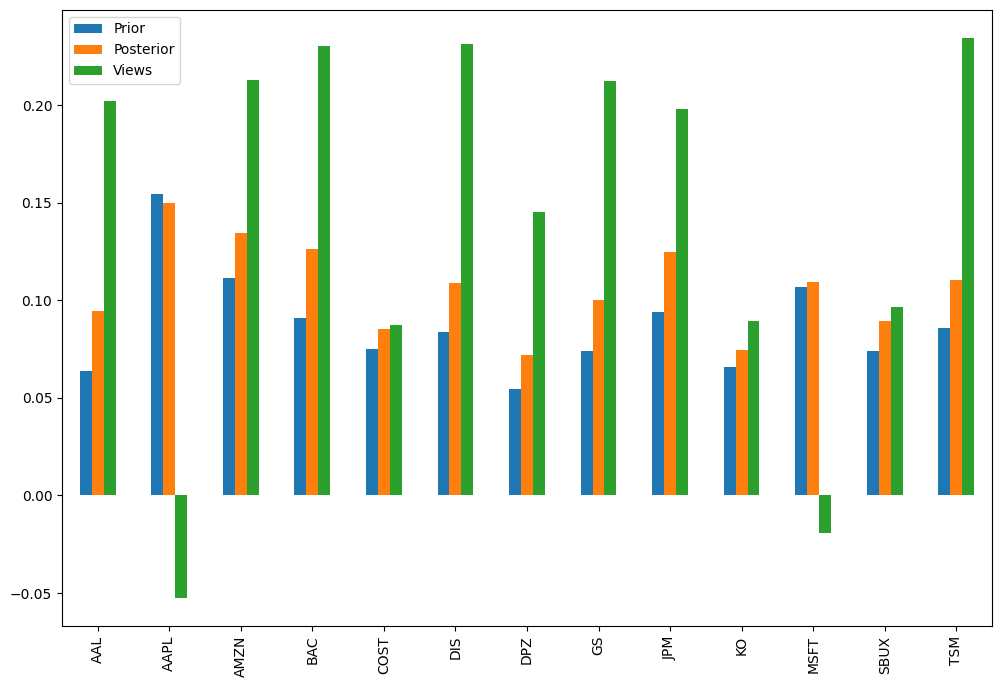

In [521]:
rets_df.plot.bar(figsize=(12, 8))

To make sure that the calculations are correct, the posterior excess return should be the bayesian average between prior and our views. If it's not, the result may be not so accurate theoretically

## Update the posterior covarance matrix

In [522]:
_tau_sigma_P = tau * cov_matrix @ P.T
_A = (P @ _tau_sigma_P) + omega

b = _tau_sigma_P.T
part1 = tau * cov_matrix 
part2 = _tau_sigma_P @ np.linalg.solve(_A, b)
M = part1.values - part2.values
posterior_cov = cov_matrix + M
S_bl = pd.DataFrame(posterior_cov, index=tickers, columns=tickers)

print(S_bl)

           AAL      AAPL      AMZN       BAC      COST       DIS       DPZ  \
AAL   0.111129  0.014410  0.016698  0.034950  0.011405  0.016020  0.023509   
AAPL  0.014410  0.151044  0.030627  0.029100  0.022523  0.027255  0.008708   
AMZN  0.016698  0.030627  0.148567  0.025812  0.019090  0.022381  0.011284   
BAC   0.034950  0.029100  0.025812  0.124921  0.021950  0.034461  0.015923   
COST  0.011405  0.022523  0.019090  0.021950  0.064699  0.019269  0.006958   
DIS   0.016020  0.027255  0.022381  0.034461  0.019269  0.106178  0.009460   
DPZ   0.023509  0.008708  0.011284  0.015923  0.006958  0.009460  0.033796   
GS    0.022788  0.019911  0.024002  0.038147  0.013849  0.019199  0.012238   
JPM   0.028357  0.031983  0.028266  0.066162  0.023853  0.031962  0.015296   
KO    0.008160  0.017234  0.007708  0.021680  0.012349  0.027019  0.004809   
MSFT  0.011334  0.036384  0.027234  0.026094  0.021484  0.024929  0.008011   
SBUX  0.018540  0.021001  0.025630  0.025040  0.017568  0.017603

## Diversifications
If you put assets that belongs to different sectors, that's good, we can cover each sectors with a percentage, you can find the description of these constraints [here](https://childlike-browser-849.notion.site/Operations-Research-Project-1658df813e6448f791aa0cf0ffc28733), there were only alpha, beta and gamma in the original exercise, now we scale it into a matrix

In [523]:
#type_parameters = [0.2, 0.2, 0.2, 0.1, 0.0]
type_constraints = pd.Series(sectors).unique().astype('U')
type_parameters = [0.3 / len(type_constraints)]*len(type_constraints)
constrains_param = [(i, j) for i, j in zip(type_constraints, type_parameters)] 
constrains_param

[('Technology', 0.049999999999999996),
 ('Consumer Cyclical', 0.049999999999999996),
 ('Financial Services', 0.049999999999999996),
 ('Communication Services', 0.049999999999999996),
 ('Consumer Defensive', 0.049999999999999996),
 ('Industrials', 0.049999999999999996)]

In [524]:
constraints_table = pd.DataFrame(data=sectors, index=type_constraints)
#constraints_table.loc['Technology'] = 1 if constraints_table.iloc[]
for j in range(len(tickers)):
  for i in range(len(type_constraints)):
    constraints_table.iloc[i, j] = 1 if constraints_table.iloc[i, j] == constraints_table.index[i] else 0

constraints_table

,MSFT,AMZN,BAC,DPZ,DIS,KO,JPM,COST,SBUX,AAPL,TSM,GS,AAL
Technology,1,0,0,0,0,0,0,0,0,1,1,0,0
Consumer Cyclical,0,1,0,1,0,0,0,0,1,0,0,0,0
Financial Services,0,0,1,0,0,0,1,0,0,0,0,1,0
Communication Services,0,0,0,0,1,0,0,0,0,0,0,0,0
Consumer Defensive,0,0,0,0,0,1,0,1,0,0,0,0,0
Industrials,0,0,0,0,0,0,0,0,0,0,0,0,1


You can check if they belongs to the right sector

# Solve the optimization problem
I used gurobi optimizer, you can use any commercial solver to solve this, the objective function is a typical formula derived from the theory of mean-variance optimization. The formula is 

$ max z = W_{t+1} = \sum_{i=1}^N x_{i,t}r_{i, t+1} - x^TΣx \\s.t.\quad \\  \sum_{i=1}^N x_{i,t} = 1\\ \sum_{i=1}^N x_{i,t}a_{i,t} \ge \alpha W_t \\\sum_{i=1}^N x_{i,t}b_{i,t} \ge \beta W_t \\ \sum_{i=1}^N x_{i,t}c_{i,t} \ge \gamma W_t  \\ x_{i,t} \ge 0 \quad \forall i = 1...n $

$r$ is the posterior excess returns we just calculated from the black litterman mdoel

$Σ$ is the posterior covarience matrix

In [525]:
import gurobipy as gp
from gurobipy import GRB


# Define the optimization problem
r = rets_bl.to_numpy() # objective function coefficients

# Create a Gurobi model
model = gp.Model()
x = model.addMVar(len(tickers))

quad_objective = r.T @ x -  x.T @ S_bl.to_numpy() @ x
# Set the objective function
#model.setObjective(gp.quicksum(r[i]*x[i] for i in range(length)), sense=gp.GRB.MAXIMIZE)
model.setObjective(quad_objective, GRB.MAXIMIZE);

# Add constraints
model.addConstr(gp.quicksum(x[i] for i in range(len(tickers))) == 1)
for i in range(len(type_parameters)):
  model.addConstr(gp.quicksum(x[j] * constraints_table.iloc[i, j] for j in range(len(tickers))) >= constrains_param[i][1])


# Optimize the model
model.optimize()

# Extract the results
weights = []
if model.status == gp.GRB.OPTIMAL:
    print(f"Optimal objective value:{model.objVal}%")
    print("Optimal decision variables:")
    weights = [x[i].x.item() for i in range(len(tickers))]
    
weights_me = [round(w, 5) for w in weights]
weights_me

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 7 rows, 13 columns and 26 nonzeros
Model fingerprint: 0x9370e943
Model has 91 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-02, 1e-01]
  QObjective range [2e-02, 3e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+00]
Presolve removed 2 rows and 0 columns
Presolve time: 0.02s
Presolved: 5 rows, 13 columns, 24 nonzeros
Presolved model has 91 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 12
 AA' NZ     : 1.200e+02
 Factor NZ  : 1.530e+02
 Factor Ops : 1.785e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal    

[0.05135,
 0.19059,
 0.1369,
 0.07523,
 0.05,
 0.07443,
 0.02484,
 0.09097,
 0.091,
 0.0,
 0.10498,
 0.0,
 0.10972]

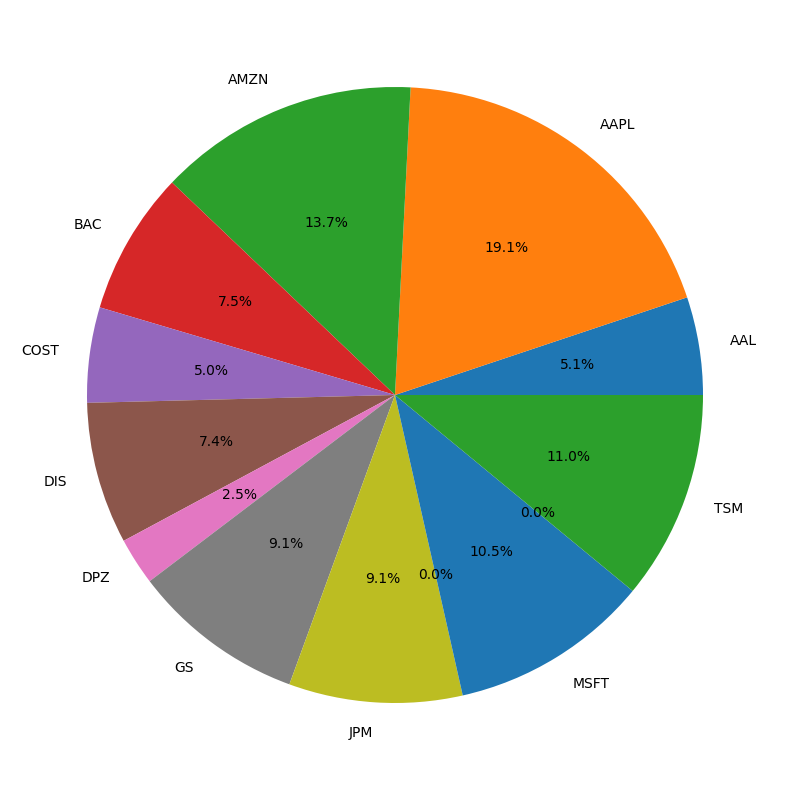

In [526]:
pd.Series(weights_me, tickers).plot.pie(figsize=(10,10), autopct='%1.1f%%');

# Result & Comparison

If I invested using the weights calculated from the model, that's amount of money I would have today, remember I had 1 dollar.

In [527]:
bought_shares = weights_me / prices.iloc[-simulation_day: -simulation_day+1]
value_today = prices.tail(1).to_numpy() * bought_shares.to_numpy()
value_today = pd.Series(value_today.squeeze(), index=tickers)
print(f'I would have {np.sum(prices.tail(1).to_numpy() * bought_shares.to_numpy())} today')

I would have 4.405464838769153 today


[0.05135, 0.19059, 0.1369, 0.07523, 0.05, 0.07443, 0.02484, 0.09097, 0.091, 0.0, 0.10498, 0.0, 0.10972]


<Axes: >

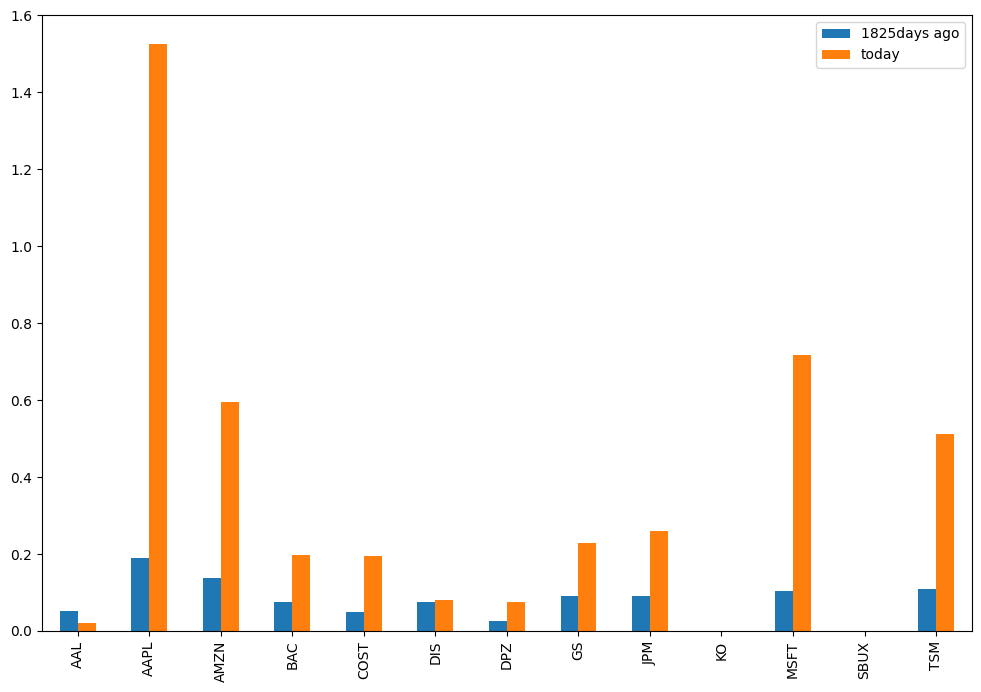

In [528]:
print(weights_me)
rets_today_df = pd.DataFrame([pd.Series(weights_me, index=tickers), value_today], 
             index=[f"{simulation_day}days ago", "today"]).T

rets_today_df.plot.bar(figsize=(12, 8))

You can clearly see which company in the long term made more money.

If invested a the same fraction for all assets equally, that's the amount of money I would have now, always had 1 dollar on the start

In [529]:
bought_shares = [1 / len(tickers)]*len(tickers) / prices.iloc[-simulation_day:-simulation_day+1]
value_today = prices.tail(1).to_numpy() * bought_shares.to_numpy()
value_today = pd.Series(value_today.squeeze(), index=tickers)
print(f'I would have {np.sum(prices.tail(1).to_numpy() * bought_shares.to_numpy())} today')

I would have 3.405369332731043 today


[0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693]


<Axes: >

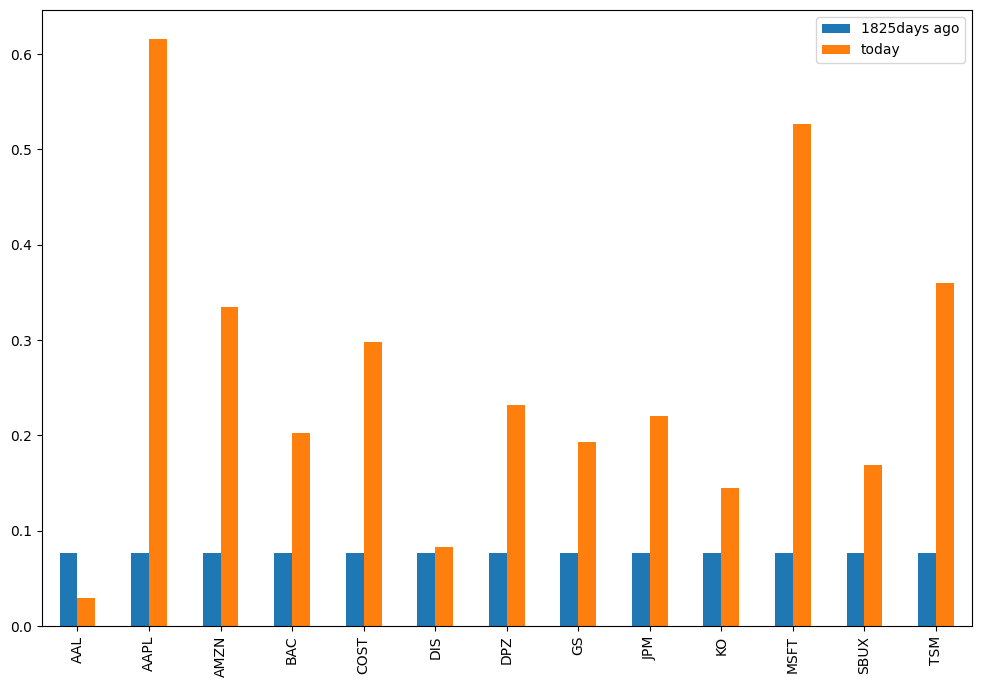

In [530]:
print([1 / len(tickers)]*len(tickers))
rets_today_df = pd.DataFrame([pd.Series([1 / len(tickers)]*len(tickers), index=tickers), value_today], 
             index=[f"{simulation_day}days ago", "today"]).T

rets_today_df.plot.bar(figsize=(12, 8))

# Conclusion
- Since I am using analysts' view, some controversial stocks have really diverse views, so it might not be accurate, like tesla 3 years ago, it was the most shorted stock, but today it had a lot of gains.
- View changes the output dramatically, even if I use low confidence, the output still tries to "believe" that your views are true and accurate.
- If you don't know how to invest, the average in each stock equally actually beats the wrong model.  
- Time span of investment is essential, you have to pick the right stocks for the long run.
- Stocks with little historic data can be computed, but less accurate.
- Fun fact, If you have fear, put the lowers target price, and the model will output more weight on defensive stocks; If you are greedy, the model tries to all in on those stocks with the most gains 
# Parameters are put to demonstrate a demo, don't trust the result you see on this page. No financial advice!!!!